<a href="https://colab.research.google.com/github/freida20git/nanoparticle-classification/blob/main/cubes/cubes_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

3 types of detections

data1: cubes, pyramids,

data2: triangles, circle, truncated

data3: dots, other


# create directories:

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!mkdir cubes_data

In [ ]:
!cp -r '/content/drive/MyDrive/cubes_new/cubes_train' /content/cubes_data
!cp -r '/content/drive/MyDrive/cubes_new/cubes_val_new' /content/cubes_data/cubes_val
!cp -r '/content/drive/MyDrive/cubes_new/cubes_test' /content/cubes_data

In [ ]:
!rm -r '/content/prefixed_flat_images'

In [ ]:
import os
import shutil

# Assuming CLASS_MAP is defined elsewhere
CLASS_MAP = {
    "cubes": 0,
    "pyramides": 1,
}

def copy_and_prefix_images(src_base_dir, dst_flat_dir):
    """
    Copies image files from a structured directory (train/validation/test/class),
    replaces the initial part of the filename with class_split, and saves them
    in a single flat destination directory. Original files are untouched.
    """
    os.makedirs(dst_flat_dir, exist_ok=True)

    for split_folder in ['cubes_train', 'cubes_val', 'cubes_test']:
        # Determine the split name (train, valid, test)
        if split_folder == 'cubes_train':
            split_name = 'train'
        elif split_folder == 'cubes_val':
            split_name = 'valid'
        elif split_folder == 'cubes_test':
            split_name = 'test'
        else:
            continue
        for cls in CLASS_MAP.keys():
            src_folder = os.path.join(src_base_dir, split_folder, cls)
            if os.path.exists(src_folder):
                for filename in os.listdir(src_folder):
                    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                        # Split the filename into parts
                        name, ext = os.path.splitext(filename)
                        parts = name.split('_')
                        if len(parts) ==7:
                            if parts[2]=='fake':
                              parts.remove('fake')
                            else:
                              print(f"Skipping invalid filename format: {filename}")
                              continue
                        # Construct the new prefix
                        new_prefix = [cls, f"cubes_{split_name}"] # Example: ['cubes', 'cubes_train']

                        num_parts_to_replace = 2

                        # Get the parts to keep
                        parts_to_keep = parts[num_parts_to_replace:]

                        # Combine the new prefix with the parts to keep
                        new_name_parts = new_prefix + parts_to_keep

                        # Join the new parts to form the new filename base
                        new_name_base = '_'.join(new_name_parts)

                        # Construct the final new filename with extension
                        new_filename = new_name_base + ext

                        src_path = os.path.join(src_folder, filename)
                        dst_path = os.path.join(dst_flat_dir, new_filename)

                        shutil.copy2(src_path, dst_path)  # Copy without modifying original
# Example usage
src_directory = '/content/cubes_data'
dst_directory = '/content/prefixed_flat_images'

copy_and_prefix_images(src_directory, dst_directory)
print(f"All images copied with class prefix to: {dst_directory}")

All images copied with class prefix to: /content/prefixed_flat_images


In [ ]:
!rm -r '/content/cubes'

In [ ]:
!cp -r '/content/drive/MyDrive/cubes' /content

In [ ]:
from PIL import Image
import os
def find_image_sizes(base_dir):
    image_dict={}
    try:
      for i in os.listdir(base_dir):
          for j in os.listdir(os.path.join(base_dir,i)):
            image_path=os.path.join(base_dir,i,j)
            with Image.open(image_path) as img:
                width, height = img.size
              #  name=j[len(base_dir)+1:]
                name= os.path.splitext(j)[0]
                image_dict[name]=(width,height)
                print("Image:", j)
                print(f"Size: {width}x{height}")
      return image_dict
    except FileNotFoundError:
        print("Error: Image file not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

In [ ]:
ORIGINAL_IMAGE_SIZES=find_image_sizes('cubes')

Image: cubes_train.jpg
Size: 337x583
Image: cubes_valid.jpg
Size: 1024x1024
Image: cubes_test.jpg
Size: 327x486


In [ ]:
import os

def clean_filenames(directory):
    """
    Removes '(number)' patterns from the end of filenames before the extension.
    """
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            name, ext = os.path.splitext(filename)
            # Use a regular expression to find and remove '(number)' at the end
            import re
            cleaned_name = re.sub(r' \(\d+\)$', '', name)
            if cleaned_name != name:
                new_filename = cleaned_name + ext
                old_path = os.path.join(directory, filename)
                new_path = os.path.join(directory, new_filename)
                try:
                    os.rename(old_path, new_path)
                    print(f"Renamed '{filename}' to '{new_filename}'")
                except OSError as e:
                    print(f"Error renaming file {filename}: {e}")

# Run the cleaning function on your image directory
image_directory = '/content/prefixed_flat_images'
clean_filenames(image_directory)

In [ ]:
def create_yolo_labels_single_file(image_dir, base_dir):
    # Prepare detections per split
    detections_per_split = {
        'train': {},
        'valid': {},
        'test': {}
    }

    for filename in os.listdir(image_dir):
        if not filename.endswith(('.jpg', '.png')):
            continue

        name_parts = filename.split('.')[0].split('_')
        # Check for the expected minimum number of parts
        if len(name_parts) < 7:
             print(f"Skipping invalid filename format: {filename}")
             continue

        # Split ID is usually the 3rd part (index 2)
        split_id_part = name_parts[2]
        split = ''.join(filter(str.isalpha, split_id_part)) # Extract the alphabetic part (train, valid, test)
        image_id = f"{base_dir}_{split_id_part}" # Use the full split ID (e.g., train1) as the key

        try:
            bbox_start_index = -4 # Assuming the last 4 parts are bbox coordinates
            # Extract and convert bounding box coordinates
            x1 = int(name_parts[bbox_start_index])
            y1 = int(name_parts[bbox_start_index + 1])
            x2 = int(name_parts[bbox_start_index + 2])
            y2 = int(name_parts[bbox_start_index + 3])

            # Ensure bounding box coordinates are valid
            if x1 >= x2 or y1 >= y2:
                 print(f"Invalid bounding box dimensions (x1 >= x2 or y2 >= y1) for image '{image_id}': {filename}")
                 continue

            if image_id not in ORIGINAL_IMAGE_SIZES:
                print(f"Unknown image key '{image_id}' in filename: {filename}")
                continue

        except (ValueError, IndexError) as e :
            print(f"Invalid bbox values or filename format in {filename}: {e}")
            continue
        except KeyError as e:
             print(f"Missing image size data for key {e} in filename: {filename}")
             continue
        class_id = CLASS_MAP.get(name_parts[0])
        if class_id is None:
            print(f"Unknown class '{name_parts[0]}' in filename: {filename}")
            continue

        # Convert (x1, y1, x2, y2) to YOLO (x_center, y_center, w, h)
        w = x2 - x1
        h = y2 - y1
        x_center = x1 + (w / 2)
        y_center = y1 + (h / 2)
        img_w, img_h = ORIGINAL_IMAGE_SIZES[image_id]

        # Normalize the values
        if x_center < img_w and y_center < img_h:
            x_center_norm = x_center / img_w
            y_center_norm = y_center / img_h
            w_norm = w / img_w
            h_norm = h / img_h

            # Add detection to the correct split
            if image_id not in detections_per_split[split]:
                detections_per_split[split][image_id] = []

            detections_per_split[split][image_id].append(
                f"{class_id} {x_center_norm:.6f} {y_center_norm:.6f} {w_norm:.6f} {h_norm:.6f}"
            )
        else: print(f"Invalid bounding box dimensions for image '{image_id}': {filename}")

    # Write YOLO label files per split
    for split, detections_dict in detections_per_split.items():
        # Ensure the split directory exists within the base_dir
        split_dir = os.path.join(base_dir, split)
        directory=os.path.join(split_dir, 'labels')
        os.makedirs(directory, exist_ok=True)
        for image_id, detections in detections_dict.items():
            # The label path should be within the split directory
            label_path = os.path.join(directory, f"{image_id}.txt")
            with open(label_path, 'w') as f:
                f.write('\n'.join(detections) + '\n')


In [ ]:
create_yolo_labels_single_file("prefixed_flat_images", 'cubes')

Invalid bounding box dimensions for image 'cubes_train': pyramides_cubes_train_492_0_613_83.jpg
Invalid bounding box dimensions for image 'cubes_train': pyramides_cubes_train_413_1483_492_1536.jpg
Invalid bounding box dimensions for image 'cubes_train': pyramides_cubes_train_137_1107_216_1196.jpg
Invalid bounding box dimensions for image 'cubes_train': pyramides_cubes_train_97_1295_214_1392.jpg
Invalid bounding box dimensions for image 'cubes_train': pyramides_cubes_train_348_159_453_269.jpg
Invalid bounding box dimensions for image 'cubes_train': pyramides_cubes_train_457_651_567_776.jpg


In [ ]:
import cv2
import numpy as np
import os # Import os module

def process_yolo_labels(base_dir, base_filename):
    # Load image
      label_path = f"{base_dir}/labels/{base_filename}.txt"
      image_path = f"{base_dir}/{base_filename}.jpg"
      image = cv2.imread(image_path)
      if image is None: # Added check for successful image loading
          print(f"Error: Could not load image from {image_path}")
          return

      h, w = image.shape[:2]
      black_image = np.zeros_like(image)  # Create black canvas

      # Read YOLO label file
      if not os.path.exists(label_path): # Added check for label file existence
          print(f"Error: Label file not found at {label_path}")
          return

      with open(label_path, 'r') as f:
          lines = f.readlines()

      for line in lines:
          parts = line.strip().split()
          if len(parts) != 5:
              continue  # Skip invalid lines

          class_id, x_center, y_center, box_w, box_h = map(float, parts)

          # Convert YOLO format (normalized) to pixel coordinates
          x_center *= w
          y_center *= h
          box_w *= w
          box_h *= h
          x1 = int(x_center - box_w / 2)
          y1 = int(y_center - box_h / 2)
          x2 = int(x_center + box_w / 2)
          y2 = int(y_center + box_h / 2)

          # Ensure bounding box coordinates are within image bounds
          x1, y1, x2, y2 = max(0, x1), max(0, y1), min(w, x2), min(h, y2)
          if x1 >= x2 or y1 >= y2: # Skip invalid or empty boxes
              print(f"Warning: Invalid or empty bounding box for line: {line.strip()}")
              continue

          # Paste the detected object onto the black image
          black_image[y1:y2, x1:x2] = image[y1:y2, x1:x2]

      output_dir=os.path.join(base_dir, 'images')
      os.makedirs(output_dir, exist_ok=True)
      output_path = os.path.join(output_dir, f"{base_filename}.jpg") # Example: save as JPEG
      cv2.imwrite(output_path, black_image)
      print(f"Saved result to {output_path}")

process_yolo_labels('/content/cubes/train', 'cubes_train')
process_yolo_labels('/content/cubes/valid', 'cubes_valid')

Saved result to /content/cubes/train/images/cubes_train.jpg
Saved result to /content/cubes/valid/images/cubes_valid.jpg


In [ ]:
test_file=os.path.join('/content/cubes/test', 'images')
os.mkdir(test_file)
shutil.move('/content/cubes/test/cubes_test.jpg', test_file)

FileExistsError: [Errno 17] File exists: '/content/cubes/test/images'

In [ ]:
import shutil
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the source directory (the folder you want to upload)
source_dir = '/content/cubes'

destination_dir = '/content/drive/My Drive/cubes_yolo'

# Ensure the destination directory exists
os.makedirs(destination_dir, exist_ok=True)

# Copy the contents of the source directory to the destination directory
try:
    shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)
    print(f"Folder '{source_dir}' successfully uploaded to '{destination_dir}'")
except FileExistsError:
    print(f"Warning: Destination directory '{destination_dir}' already exists. Contents will be merged.")
    shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)
except Exception as e:
    print(f"An error occurred: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Folder '/content/cubes' successfully uploaded to '/content/drive/My Drive/cubes_yolo'


# import from google drive:

In [ ]:
import gdown
import zipfile

# Replace with your Google Drive folder URL
folder_url='https://drive.google.com/drive/folders/1-A7IlSmZ3pCu_YMcmveofxHu3hKZOQpV?usp=sharing'
output_zip_filename = "cubes"
gdown.download_folder(folder_url, output=output_zip_filename, quiet=False)

Retrieving folder contents


Retrieving folder 122pmeMP3xz5rw9EHEWoGVuZLDllg0H4V test
Retrieving folder 1S3mPS7LenaKfNikWD-xGNbRG8H_qi3Cz images
Processing file 1z3EksKLFtDhBO3Rs2jgPQPnIkGiGdMV5 cubes_test.jpg
Retrieving folder 1T20wjsHdotY7-bHlainxu9w0lWTWeK3H labels
Processing file 1btSkCy5F8Nr14aKOtG4BwlfZlgux2-LM cubes_test.txt
Retrieving folder 1I6wVcz8bwhinB3eXquXwc75ZjH3gCTLs train
Retrieving folder 1TdoMvFow1MSrAaxMpQnw_t6epV0Qg3rb images
Processing file 1kMtH21pCxFXx3Stcvha1k1LVhxImFLVT cubes_train.jpg
Retrieving folder 1JrIPBtHKonO9mOtTUAF0ffwgPTMzdvGd labels
Processing file 1L76MBy-RhPkQpyDeANM12hCPFkuFcjOJ cubes_train.txt
Processing file 1-Eo0jkuMgSVYWgnYPKw97AgzfrfCG7a7 cubes_train.jpg
Retrieving folder 14AiwJhYT85eCsvcWXJ5GRntP-UBeJ8zX valid
Retrieving folder 160kem_iVYLceiuC_xdTtkt8de8xPa4-g images
Processing file 1g7zVQNBgGL8uJXwALXaYu-UPTSquhSFx cubes_valid.jpg
Retrieving folder 1MfIlJ3iakjzRZ5Y6fYBw4wqt8FwuSKVh labels
Processing file 1AAP9iogcu_8QW7ohrqTB4DdowdapUc3S cubes_valid.txt
Processing fi

Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1z3EksKLFtDhBO3Rs2jgPQPnIkGiGdMV5
To: /content/cubes/test/images/cubes_test.jpg
100%|██████████| 31.1k/31.1k [00:00<00:00, 40.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1btSkCy5F8Nr14aKOtG4BwlfZlgux2-LM
To: /content/cubes/test/labels/cubes_test.txt
100%|██████████| 7.07k/7.07k [00:00<00:00, 15.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kMtH21pCxFXx3Stcvha1k1LVhxImFLVT
To: /content/cubes/train/images/cubes_train.jpg
100%|██████████| 11.2k/11.2k [00:00<00:00, 17.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1L76MBy-RhPkQpyDeANM12hCPFkuFcjOJ
To: /content/cubes/train/labels/cubes_train.txt
100%|██████████| 494/494 [00:00<00:00, 1.02MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-Eo0jkuMgSVYWgnYPKw97AgzfrfCG7a7
To: /content/cubes/train/cubes_train.jpg
100%|██████████| 37.5k/37.5k

['cubes/test/images/cubes_test.jpg',
 'cubes/test/labels/cubes_test.txt',
 'cubes/train/images/cubes_train.jpg',
 'cubes/train/labels/cubes_train.txt',
 'cubes/train/cubes_train.jpg',
 'cubes/valid/images/cubes_valid.jpg',
 'cubes/valid/labels/cubes_valid.txt',
 'cubes/valid/cubes_valid.jpg']

### check if bounding boxes are correct:

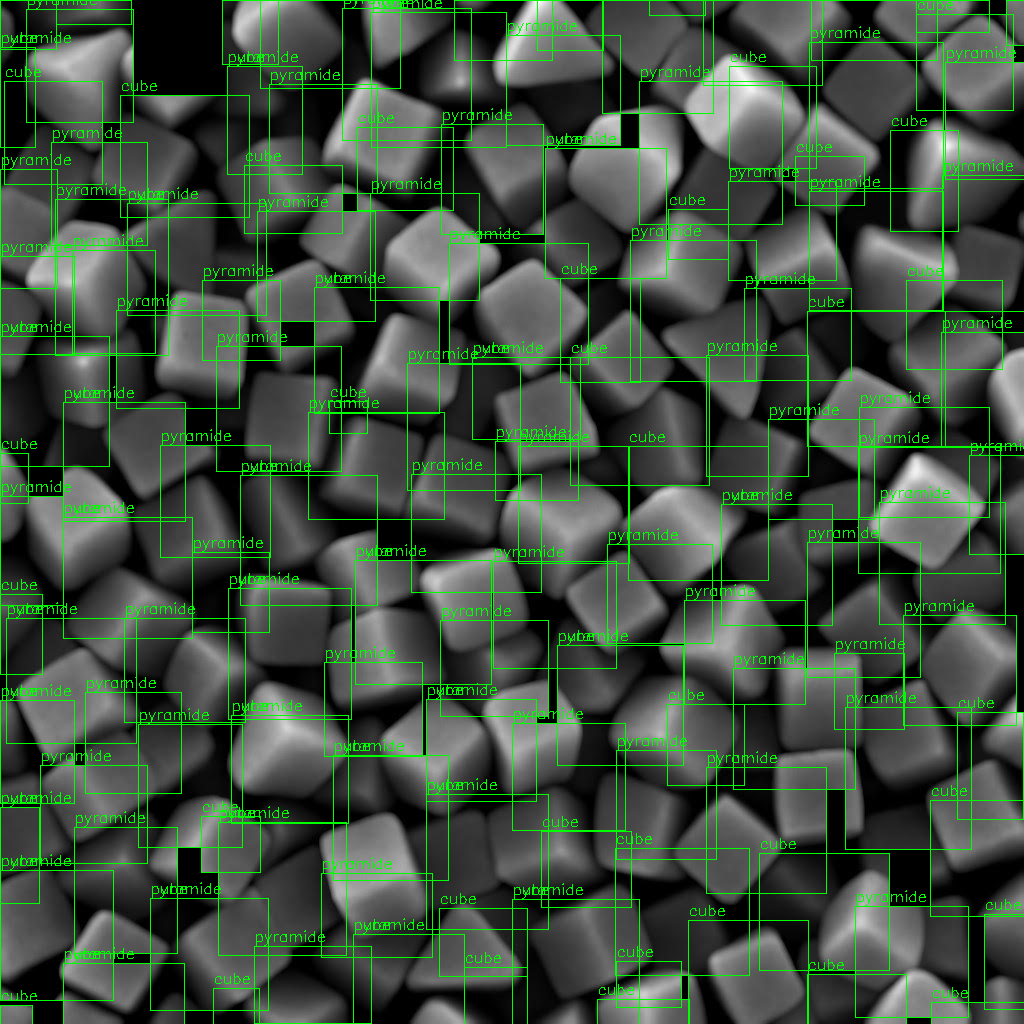

In [ ]:
import cv2
import os
from google.colab.patches import cv2_imshow

def draw_yolo_boxes_on_image(image_path, label_path, class_names):
    """
    Draws bounding boxes and labels on an image based on YOLO format label file.

    Args:
        image_path (str): Path to the image file.
        label_path (str): Path to the YOLO format label file (.txt).
        class_names (list): A list of class names corresponding to the class IDs in the label file.
    """
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not load image: {image_path}")
        return

    h, w = image.shape[:2]

    # Read YOLO label file
    if not os.path.exists(label_path):
        print(f"Label file not found at {label_path}")
        # Display the original image if no label file
        cv2_imshow(image)
        return

    with open(label_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        if len(parts) != 5:
            continue  # Skip invalid lines

        class_id, x_center, y_center, box_w, box_h = map(float, parts)

        # Convert YOLO format (normalized) to pixel coordinates
        x_center *= w
        y_center *= h
        box_w *= w
        box_h *= h
        x1 = int(x_center - box_w / 2)
        y1 = int(y_center - box_h / 2)
        x2 = int(x_center + box_w / 2)
        y2 = int(y_center + box_h / 2)

        # Ensure bounding box coordinates are within image bounds
        x1, y1, x2, y2 = max(0, x1), max(0, y1), min(w, x2), min(h, y2)
        if x1 >= x2 or y1 >= y2:  # Skip invalid or empty boxes
            print(f"Warning: Invalid or empty bounding box for line: {line.strip()}")
            continue


        # Get class name
        if 0 <= class_id < len(class_names):
            class_name = class_names[int(class_id)]
        else:
            class_name = f"Unknown_{int(class_id)}"

        # Draw rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 1) # Green color, thickness 2
        # Put class label
        cv2.putText(image, class_name, (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # Show the image with bounding boxes
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Example Usage:
# Define the path to your image and corresponding label file
image_file = '/content/cubes/valid/images/cubes_valid.jpg'
label_file = '/content/cubes/valid/labels/cubes_valid.txt'

# Define your class names in the correct order corresponding to the class IDs in the label file
my_class_names = ['cube', 'pyramide']

# Call the function to draw bounding boxes
draw_yolo_boxes_on_image(image_file, label_file, my_class_names)

validation set has wrong bounding boxes, we will ignore it and use test set instead

# train:

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
import yaml
import os
from ultralytics import YOLO
# Define the dataset structure and class names
data = {
    'path': '/content/cubes',  # Base path to your dataset
    'train': '/content/cubes/train/images',       # Relative path to training images
    'val': '/content/cubes/test/images',         # Relative path to validation images
    'nc': 2,                       # Number of classes
    'names': ['cube', 'pyramide']  # List of class names
}

# Define the path for the YAML file
yaml_file_path = 'cubes/cubes.yaml'

# Write the data to the YAML file
with open(yaml_file_path, 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

print(f"YAML file created at: {yaml_file_path}")

YAML file created at: cubes/cubes.yaml


In [ ]:
!yolo task=detect mode=train model=yolo11m.pt data=/content/cubes/cubes.yaml epochs=100 batch=1

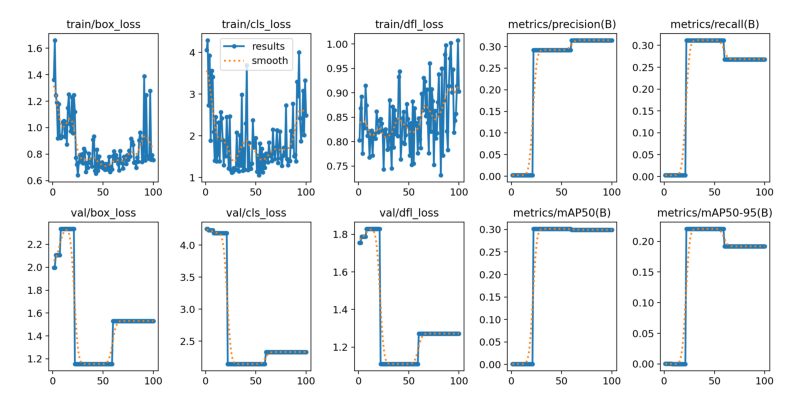

In [ ]:
import matplotlib.pyplot as plt
import cv2 # Import cv2 to read the image

# Read the image from the file path
image_path = '/content/runs/detect/train2/results.png'
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is not None:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis('off') # Hide axes for a cleaner image display
    plt.show()
else:
    print(f"Error: Could not read image from {image_path}")

In [ ]:
import matplotlib.pyplot as plt
import cv2 # Import cv2 to read the image

# Read the image from the file path
image_path = '/content/runs/detect/train2/results.png'
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is not None:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis('off') # Hide axes for a cleaner image display
    plt.show()
else:
    print(f"Error: Could not read image from {image_path}")


image 1/1 /content/cubes/test/images/cubes_test.jpg: 640x448 9 cubes, 9 pyramides, 912.8ms
Speed: 2.7ms preprocess, 912.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


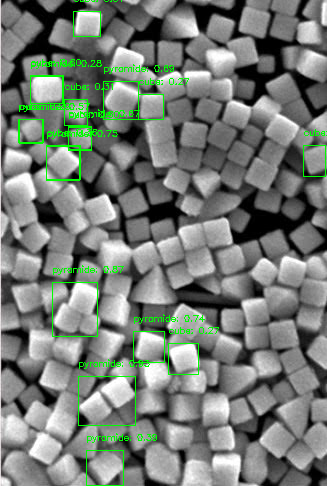

In [ ]:
import cv2
import os
from google.colab.patches import cv2_imshow
from ultralytics import YOLO

# Define the class map (reverse of your CLASS_MAP)
ID_TO_CLASS = {0:'cube',
               1: 'pyramide'}

def draw_yolo_predictions_on_image(image_path, predictions, save_path=None):
    """
    Draws YOLO predictions (bounding boxes and labels with confidence) on an image.

    Args:
        image_path (str): Path to the image file.
        predictions (list): A list of prediction results from YOLO model.predict().
                            Each item in the list should represent the predictions for one image.
                            We assume the list contains results for a single image in this function.
        save_path (str, optional): Path to save the image with predictions.
                                   If None, the image is displayed using cv2_imshow.
    """
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not load image: {image_path}")
        return

    h, w = image.shape[:2]

    # Assuming 'predictions' contains results for a single image
    if len(predictions) == 0:
        print(f"No predictions found for image: {image_path}")
        if save_path:
            cv2.imwrite(save_path, image) # Save the original image if no predictions
        else:
            cv2_imshow(image)
        return

    # We expect the predictions for one image in the first element of the list
    results = predictions[0]

    if results.boxes is not None:
        for box in results.boxes:
            # Extract bounding box coordinates in pixel values
            x1, y1, x2, y2 = map(int, box.xyxy[0])

            # Extract class ID and confidence
            class_id = int(box.cls[0])
            confidence = float(box.conf[0])

            class_name = ID_TO_CLASS.get(class_id, str(class_id))
            label = f"{class_name}: {confidence:.2f}"

            # Draw rectangle
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 1) # Green color, thickness 2
            # Put class label and confidence
            cv2.putText(image, label, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1)

    # Show or save
    if save_path:
        cv2.imwrite(save_path, image)
    else:
        cv2_imshow(image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

# Example Usage (assuming you have loaded your model and made predictions)
model = YOLO("/content/runs/detect/train2/weights/best.pt")
image_to_predict = '/content/cubes/test/images/cubes_test.jpg'
results = model.predict(source=image_to_predict, save=False, stream=False) # Get results in memory
draw_yolo_predictions_on_image(image_to_predict, results)

In [ ]:
from ultralytics import YOLO

# Load the trained model
model = YOLO("/content/runs/detect/train2/weights/best.pt")

# Run the model in validation mode on the test dataset
# The 'split' argument should be set to 'test'
results = model.val(data='/content/cubes/cubes.yaml')

precision = results.box.p  # Precision
recall = results.box.r    # Recall

print(f"Precision: {precision}")
print(f"Recall: {recall}")
f1_score = results.box.f1 # F1 Score
print(f"F1 Score: {f1_score}")

Ultralytics 8.3.158 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLO11m summary (fused): 125 layers, 20,031,574 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 690.7±0.0 MB/s, size: 30.4 KB)


val: Scanning /content/cubes/test/labels.cache... 1 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1/1 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


                   all          1        186      0.287      0.312      0.299      0.219
                  cube          1        174      0.566       0.54      0.592      0.432
              pyramide          1         12    0.00746     0.0833    0.00668    0.00534
Speed: 1.4ms preprocess, 972.5ms inference, 0.0ms loss, 78.8ms postprocess per image
Results saved to runs/detect/val3
Precision: [    0.56627   0.0074627]
Recall: [    0.54023    0.083333]
F1 Score: [    0.55294    0.013699]


F1 Score: [    0.55294    0.013699]


In [ ]:
def plot(path):
  image = cv2.imread(path)
  # Check if the image was loaded successfully
  if image is not None:
      image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      plt.figure(figsize=(10, 10))
      plt.imshow(image_rgb)
      plt.axis('off') # Hide axes for a cleaner image display
      plt.show()
  else:
      print(f"Error: Could not read image from {image_path}")

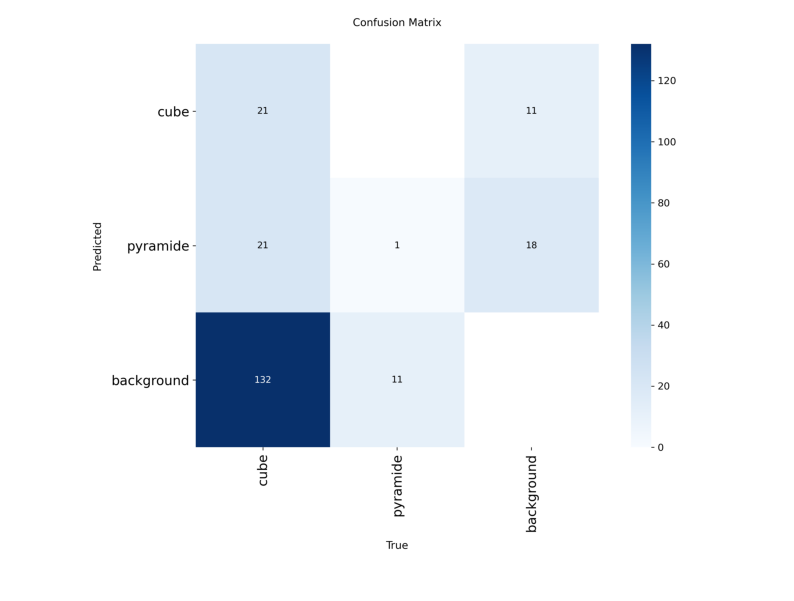

In [ ]:
plot('/content/runs/detect/val3/confusion_matrix.png')

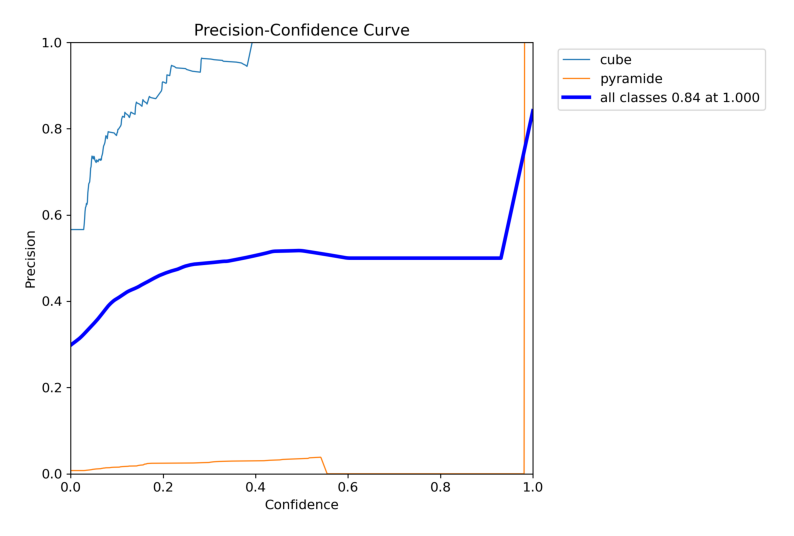

In [ ]:
plot('/content/runs/detect/val2/P_curve.png')

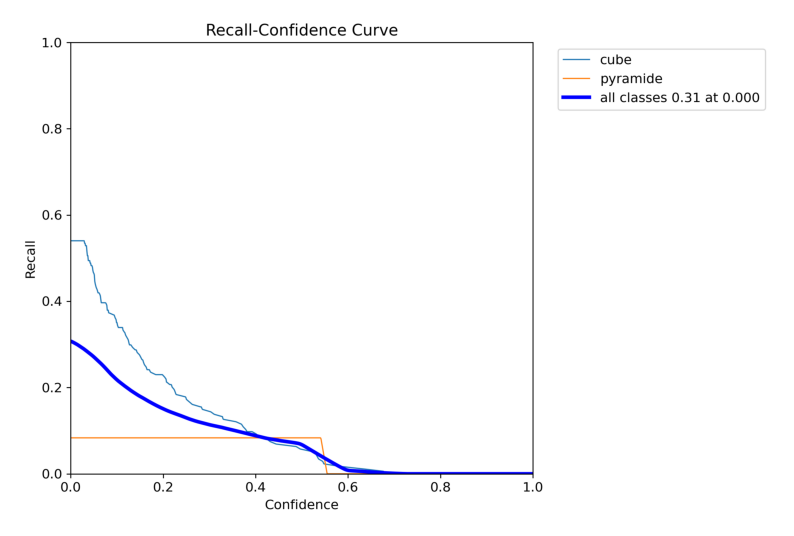

In [ ]:
plot('/content/runs/detect/val2/R_curve.png')

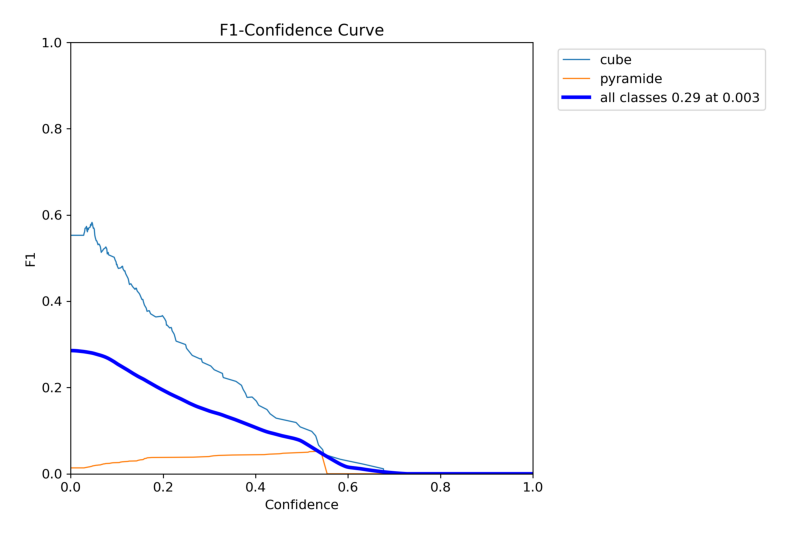

In [ ]:
plot('/content/runs/detect/val2/F1_curve.png')